# Part 1: Overview and Social Network Basics

**Author: Carolyn Parkinson**

**Email: <cparkinson@ucla.edu>**

**Lab website: http://csnlab.org**

**August 2018**

## Tutorial Overview

In this tutorial, we'll first go over some basics of working with and visualizing social network data (in this R notebook). 

Then we'll go through how to extract region-wise inter-subject fMRI response time series (dis)similarities from members of a social network we have characterized (in a second set of notebooks).

Finally, we'll relate the distance between individuals in the network to region-wise time-series similarities (in our final notebook).

This first part of the tutorial will primarily use the R package igraph. If you prefer Python, there's also an igraph module for Python that you can use. Both are based on the same C library. 

This notebook uses the R kernel, but the other notebooks are all Python-based.

In [2]:
if(!require(igraph)) install.packages("igraph"); require(igraph)
if(!require(RColorBrewer)) install.packages("RColorBrewer"); require(RColorBrewer)
if(!require(jsonlite)) install.packages("jsonlite"); require(jsonlite)

## Network Fundamentals

Any network is comprised of nodes(/vertices) connected by ties(/edges). 


Nodes in a network can be people, groups, concepts or other entities. 


The connections between nodes (i.e., edges) can also reflect many things, including interactions between nodes (e.g., who gives advice to whom, co-authorships, romantic partners, emails, phone calls), affiliations (e.g., belonging to the same club, living or working in the same place), and roles (e.g., kinship ties, friendships).

Edges can be **weighted** if they can take on varying values (e.g., to indicate the strength of a relationships or frequency of contact) or **unweighted** if they are all either 0 and 1 (e.g., the mere presence or absence of reported friendships).

Edges can also be **directed** or **undirected**. Edges based on things like common affiliations or behaviors would necessarily be **undirected** (symmetrical). However, if we define our edges based on things like who gets advice from whom, or who sends emails to whom, they would be **directed** (e.g., a connection can exist from node A to node B, and not from node B to node A).

## A Toy Example

As a quick example, we could define a network based on who supervises whom in Luke's lab, and it might look something like this, with everyone connected to Luke through a directed edge:

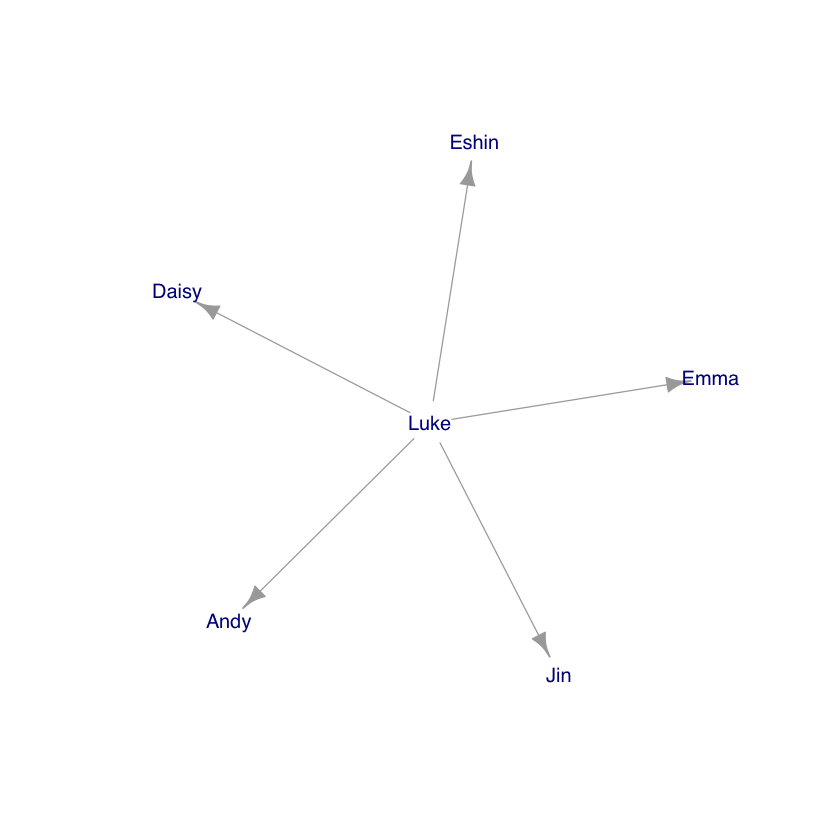

In [3]:
edges <- c("Luke", "Eshin", 
           "Luke", "Andy",
           "Luke", "Jin",
           "Luke",  "Emma", 
           "Luke", "Daisy")

g_who_supervises_whom <- graph(edges, directed = TRUE)

plot(g_who_supervises_whom, 
     vertex.label.family = "sans",
     vertex.shape = "none")

Alternatively, we could define edges between these people based on a shared attribute -- e.g., who works in Moore Hall (the building where this lab is located), in which case everyone would be connected to everyone via undirected ties:

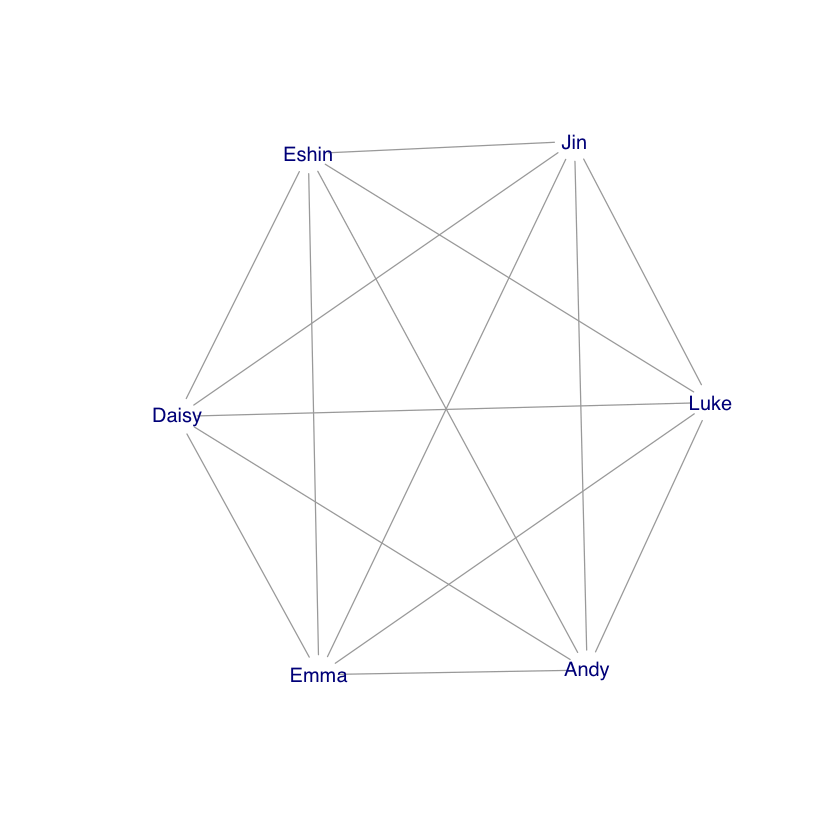

In [4]:
g_works_in_moore <- graph.full(n = length(unique(edges)), 
                               directed = FALSE, 
                               loops = FALSE)

V(g_works_in_moore)$name <- unique(edges)
plot(g_works_in_moore, vertex.label.family = "sans", vertex.shape = "none")

We wouldn't normally enter our nodes and edges  manually like in the first example above. We would usually import the data from another file, which would typically summarize the connections between nodes in the form of an **adjacency matrix**, like this (where rows indicate the source of a connection, columns indicate the connection's target, and 1's indicate the presence of a connection):

In [5]:
as_adjacency_matrix(g_who_supervises_whom)

6 x 6 sparse Matrix of class "dgCMatrix"
      Luke Eshin Andy Jin Emma Daisy
Luke     .     1    1   1    1     1
Eshin    .     .    .   .    .     .
Andy     .     .    .   .    .     .
Jin      .     .    .   .    .     .
Emma     .     .    .   .    .     .
Daisy    .     .    .   .    .     .

Or an **edge list**, like this, where there is a row corresponding to each edge, with the first column being the source and the second column being the target:

In [6]:
as_edgelist(g_who_supervises_whom)

[,1] [,2] 
[1,] Luke Eshin
[2,] Luke Andy 
[3,] Luke Jin  
[4,] Luke Emma 
[5,] Luke Daisy

## Visualizing the Network of Friendships in an Academic Cohort

### Reading in and Inspecting the Data
In the case of the social network data we'll work with today, we'll import an edge list of the reported friendships among members of an academic program. Let's read in the edge list and take a peek at what it looks like.

In [7]:
# load in the edge list
edge_list <- read.csv("./data/socialnetworks/anon_edge_list.csv")

# see what it looks like
head(edge_list)

source target
1 s001   s124  
2 s001   s218  
3 s001   s003  
4 s001   s259  
5 s001   s271  
6 s001   s214

You can see there are 2 columns: a source and a target.
In our data, in a given row, the "source" is the person who named the "target" as their friend.


Now let's convert our data from an edge list to an igraph object, and inspect it.

In [8]:
our_graph <- graph_from_data_frame(edge_list, directed = T)
our_graph

IGRAPH f6a4393 DN-- 279 7705 -- 
+ attr: name (v/c)
+ edges from f6a4393 (vertex names):
 [1] s001->s124 s001->s218 s001->s003 s001->s259 s001->s271 s001->s214
 [7] s001->s109 s001->s173 s001->s030 s001->s144 s001->s023 s001->s269
[13] s001->s204 s001->s013 s001->s146 s001->s190 s001->s005 s001->s278
[19] s001->s180 s001->s022 s001->s155 s001->s179 s001->s127 s001->s172
[25] s001->s148 s001->s062 s001->s211 s001->s262 s001->s103 s001->s092
[31] s001->s143 s001->s039 s001->s001 s001->s231 s001->s080 s001->s238
[37] s001->s178 s001->s210 s001->s196 s001->s026 s001->s059 s001->s203
[43] s001->s125 s001->s116 s001->s252 s002->s046 s002->s206 s002->s156
+ ... omitted several edges

You can see there are 279 nodes and 7,705 edges connecting them. The 2 letters preceding those numbers signify that the graph is comprised of directed edges ('D') and that the nodes have names ('N').

It's simple to access the nodes/vertices (i.e., people) and edges (i.e., reported friendships) of our graph:


In [9]:
E(our_graph)
V(our_graph)

+ 7705/7705 edges from f6a4393 (vertex names):
 [1] s001->s124 s001->s218 s001->s003 s001->s259 s001->s271 s001->s214
 [7] s001->s109 s001->s173 s001->s030 s001->s144 s001->s023 s001->s269
[13] s001->s204 s001->s013 s001->s146 s001->s190 s001->s005 s001->s278
[19] s001->s180 s001->s022 s001->s155 s001->s179 s001->s127 s001->s172
[25] s001->s148 s001->s062 s001->s211 s001->s262 s001->s103 s001->s092
[31] s001->s143 s001->s039 s001->s001 s001->s231 s001->s080 s001->s238
[37] s001->s178 s001->s210 s001->s196 s001->s026 s001->s059 s001->s203
[43] s001->s125 s001->s116 s001->s252 s002->s046 s002->s206 s002->s156
[49] s002->s203 s003->s214 s003->s146 s003->s101 s003->s060 s003->s266
[55] s004->s111 s004->s237 s004->s261 s004->s044 s004->s239 s004->s195
+ ... omitted several edges

+ 279/279 vertices, named, from f6a4393:
  [1] s001 s002 s003 s004 s005 s006 s007 s008 s009 s010 s011 s012 s013 s014 s015
 [16] s016 s017 s018 s019 s020 s021 s022 s023 s024 s025 s026 s027 s028 s029 s030
 [31] s031 s032 s033 s034 s035 s036 s037 s038 s039 s040 s041 s042 s043 s044 s045
 [46] s046 s047 s048 s049 s050 s051 s052 s053 s054 s055 s056 s057 s058 s059 s060
 [61] s061 s062 s063 s064 s065 s066 s067 s068 s069 s070 s071 s072 s073 s074 s075
 [76] s076 s077 s078 s079 s080 s081 s082 s083 s084 s085 s086 s087 s088 s089 s090
 [91] s091 s092 s093 s094 s095 s096 s097 s098 s099 s100 s101 s102 s103 s104 s105
[106] s106 s107 s108 s109 s110 s111 s112 s113 s114 s115 s116 s117 s118 s119 s120
[121] s121 s122 s123 s124 s125 s126 s127 s128 s129 s130 s131 s132 s133 s134 s135
[136] s136 s137 s138 s139 s140 s141 s142 s143 s144 s145 s146 s147 s148 s149 s150
+ ... omitted several vertices

Before we continue, let's clean up the graph to remove self loops (people who nominated themselves as friends).

In [10]:
our_graph <- simplify(our_graph, remove.loops = TRUE)

### Getting Started with Visualization
Now let's visualize the network.

In our case, the default parameters that igraph uses won't look very nice:

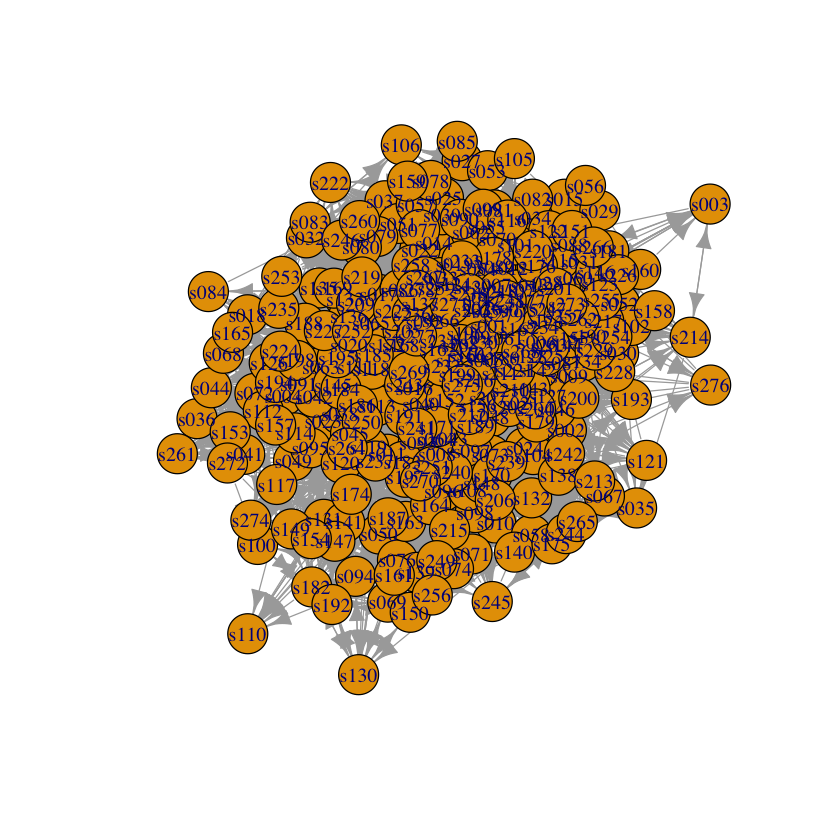

In [11]:
plot(our_graph)

That ugly jumble of shapes and letters doesn't really convey anything meaningful, but we can begin to remedy that with a few tweaks.

As a start, let's hide the labels, specify sizes for the vertices, edges, and arrows that won't cause so much overlap, and make the edges a higher-contrast color.



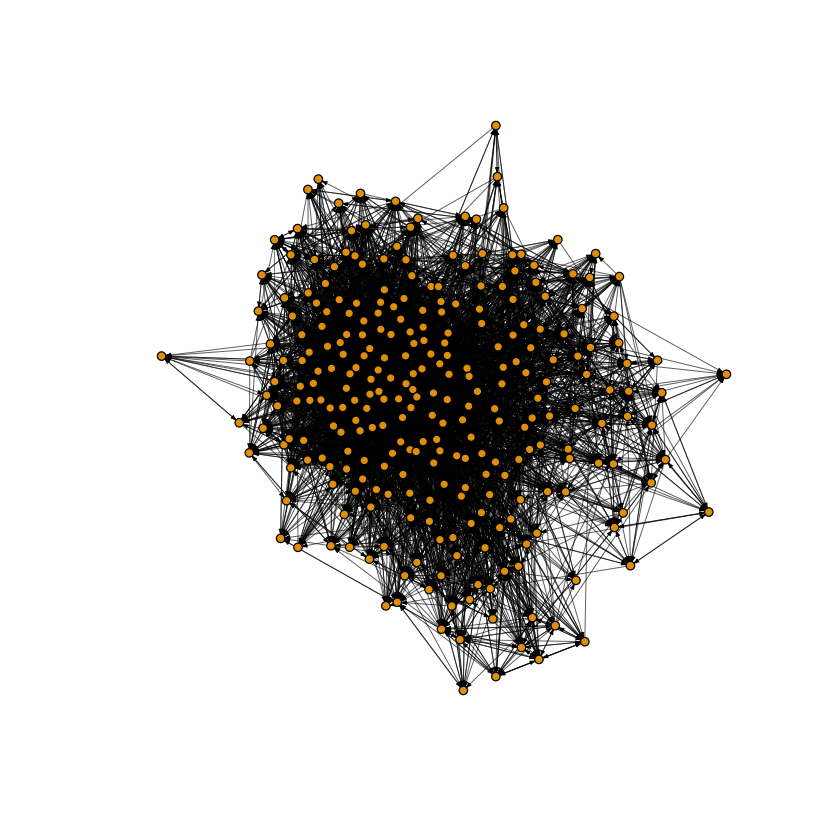

In [12]:
V(our_graph)$size <- 3
E(our_graph)$arrow.size <- 0.2
E(our_graph)$width <- 0.5
E(our_graph)$color <- "black"

plot(our_graph, vertex.label = NA)

That's starting to look *mildly* better, but we still have something of a hairball on our hands...

Since this is such a densely inter-connected network, it may be clearer to only display reciprocally reported friendships (i.e., ones that the sources and targets both reported).


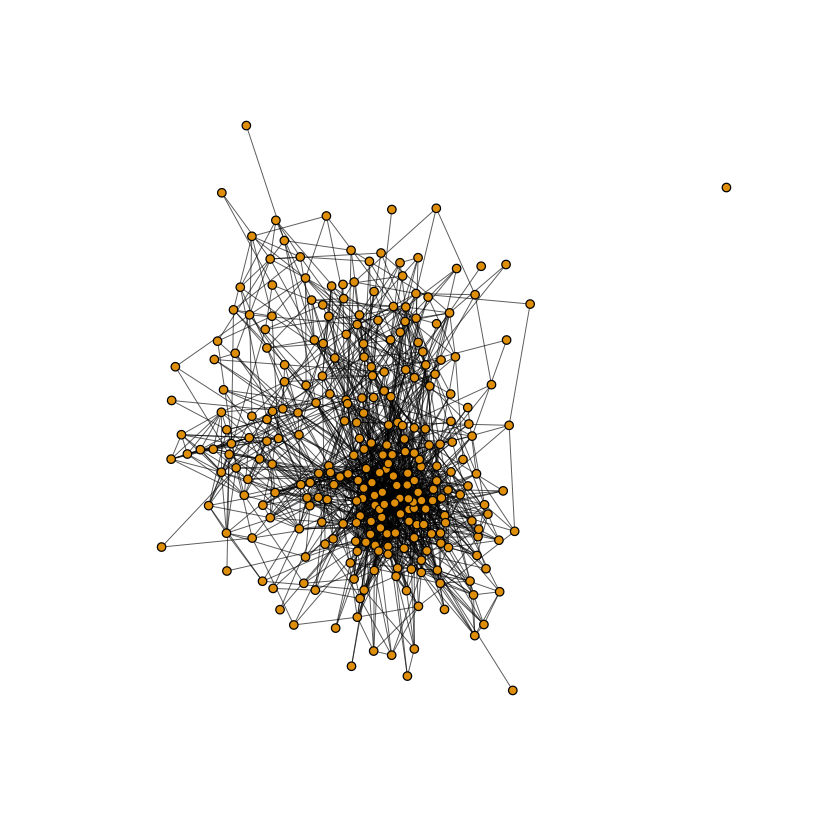

In [13]:
our_graph_mutual <- as.undirected(our_graph, mode = "mutual")

# need to reset edge attributes after making the graph undirected
E(our_graph_mutual)$color <- "black" 
E(our_graph_mutual)$width <- 0.5

# plot
plot(our_graph_mutual, vertex.label = NA)

That's starting to look a little clearer, but not great. 

You might be wondering what's determining where each node appears in the graph. 

We can use different layout algorithms that will return coordinates for each node in the graph.

By default, igraph uses a smart function called 'layout nicely' to try to choose an appropriate layout algorithm for the supplied graph, but you can also stipulate an algorithm to use.

Force-directed algorithms (e.g., Kamada Kawai, Fruchterman Reingold) typically work well for relatively large graphs. The details of how these algorithms work is beyond the scope of this tutorial, but generally, they simulate a physical system where edges are springs that pull connected nodes closer to one another, and nodes act as electrically charged particles that repel one another when they get too close. The benefit of using these kinds of algorithms is that they return layouts where the nodes are relatively evenly spaced, with nodes that share many connections located relatively close to one another.

We can try one out on our graph to generate new node coordinates:

In [14]:
coords <- layout_(our_graph_mutual, with_kk())
head(coords)

[,1]       [,2]      
[1,] -0.3477359  1.1449388
[2,] -2.6881518 -4.2899642
[3,]  1.1030745 -4.9615612
[4,] -8.7894796  0.4882561
[5,] -2.1157167  2.0143189
[6,]  4.0516033  1.5632131

As you can see, "coords" is just an N (number of nodes) by 2 matrix of x and y coordinates for each node in our graph.

Now we can plot using these coordinates:

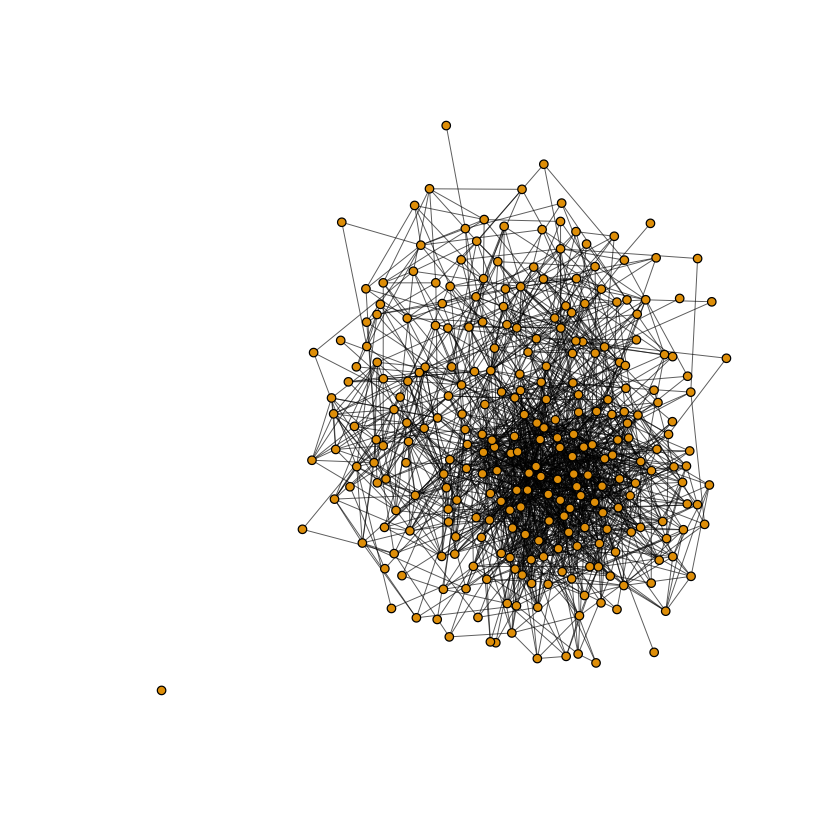

In [15]:
plot(our_graph_mutual, vertex.label = NA, layout = coords)

Notice that we have one isolate (i.e. one node without any connections). Force-directed layouts tend to work best with connected graphs, so we can remove the isolate and replot:


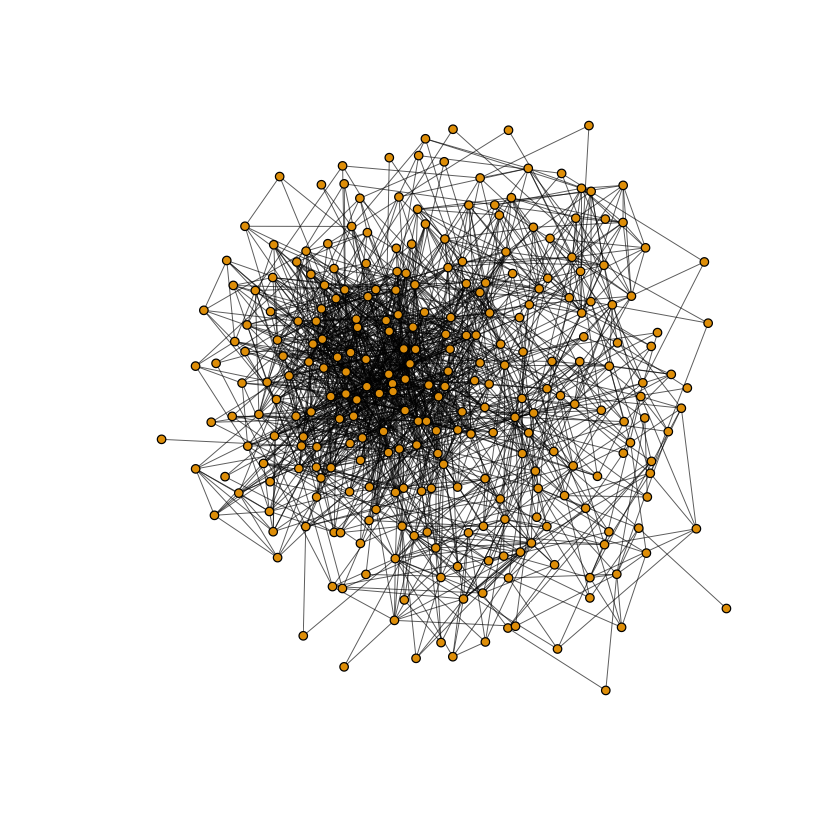

In [16]:
# identify isolates in the undirected (mutual ties only) graph
iso <- names(V(our_graph_mutual)[degree(our_graph_mutual)==0])

# remove isolates from undirected graph (for plotting)
our_graph_mutual_no_iso <- delete.vertices(our_graph_mutual, iso)

coords <- layout_(our_graph_mutual_no_iso, with_kk())

plot(our_graph_mutual_no_iso, vertex.label = NA, layout = coords)

Keep in mind that the location of a node within a graph isn't necessarily meaningful. It can be random:

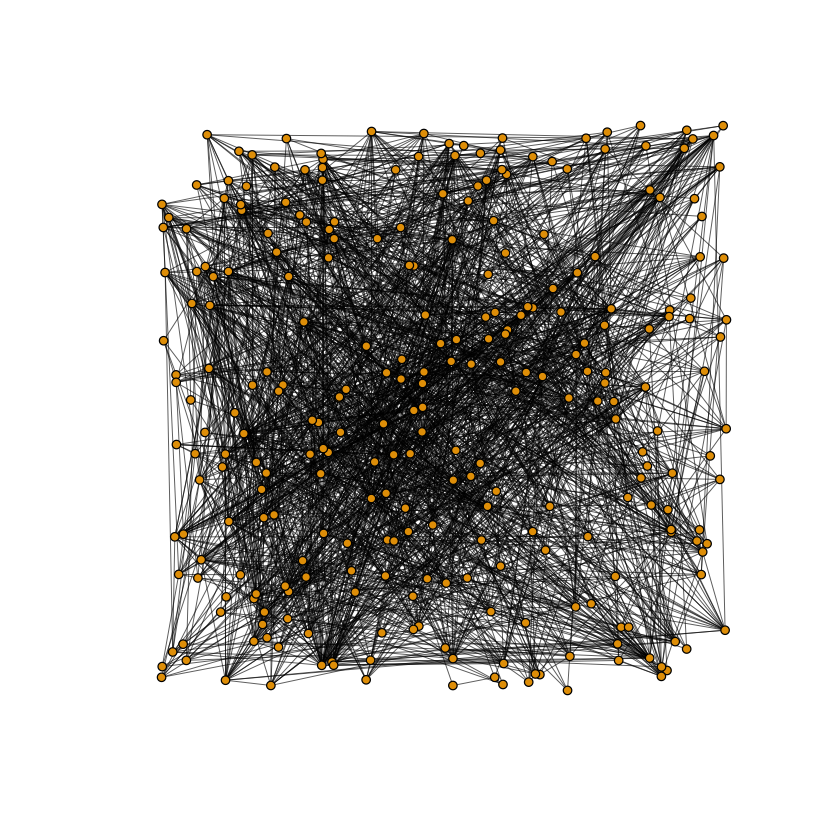

In [17]:
coords <- layout_(our_graph_mutual, randomly())
plot(our_graph_mutual, vertex.label = NA, layout = coords)

Or you could  just use a predefined shape, like a circle:


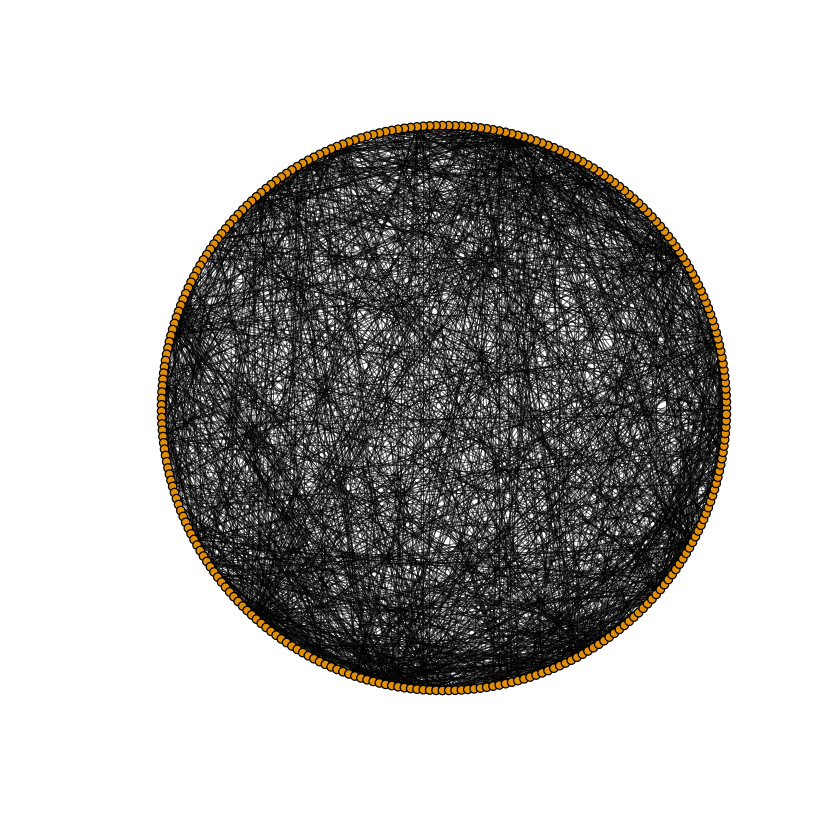

In [18]:
coords <- layout_(our_graph_mutual, in_circle())
plot(our_graph_mutual, vertex.label = NA, layout = coords)

These last 2 aren't all that informative but remind us that the depicted locations of nodes in a network visualization depend critically on the layout algorithm used to construct it, so one must be careful when reading into node location in a graph.

In any case, now we have a somewhat clearer visual depiction of the people in our community and the reciprocally reported friendships between them than what we started with.

If we were interested in ascertaining properties of the network as a whole (e.g., its community structure), we could hone our visualization further by selectively deleting nodes or edges or highlighting communities, but we will return to that later.

Here, our main goal is to visually convey the steps of our [study](http://dx.doi.org/10.1038/s41467-017-02722-7): We characterized the patterning of social ties among members of an academic cohort, and had a subset participate in an fMRI study.

To visually convey the latter point, let's indicate via vertex color the network members who completed our fMRI study. First we'll read in the IDs of the fMRI subjects:


In [19]:
fmri_subj <- fromJSON("./data/fmri/fmri_subjects.json")

Now we'll make a character vector with an element for each subject ID in our network (note: we'll ignore that single isolate for now and just focus on the giant connected component that includes most nodes). The value of a given element will be "tomato" if the corresponding person was a subject in the fMRI study and "grey" otherwise. Then, we'll apply this information as an attribute for all vertices in our graph:

In [20]:
mycols <- ifelse(V(our_graph_mutual_no_iso)$name %in% fmri_subj, 
                 "tomato", "grey")
V(our_graph_mutual_no_iso)$color <- mycols

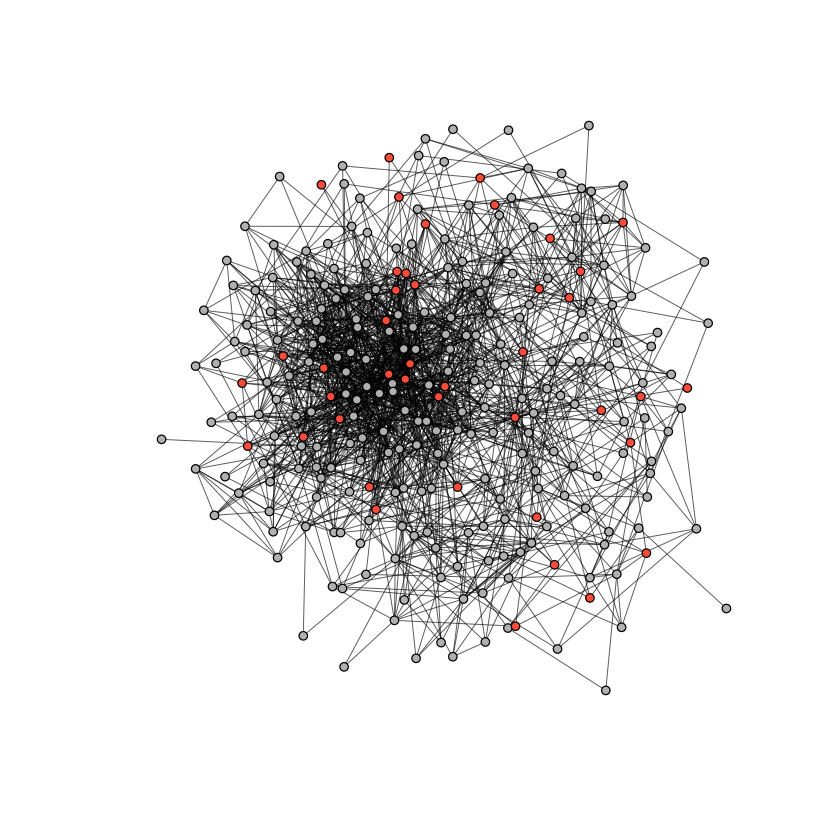

In [21]:
coords <- layout_(our_graph_mutual_no_iso, with_kk())
plot(our_graph_mutual_no_iso, vertex.label = NA, layout = coords)

The above diagram conveys aspects of our experimental design visually: That is, we characterized the friendships among members of a commnunity, then had a subset of them participate in a neuroimaging (the red nodes).

However, the visualization does not add much beyond that.

If we wanted a clearer visual indication of the structure of a network, we might in some cases want to delete certain edges (e.g., edges below a threshold in a weighted network). We may also want to visualize communities that exist in the network. There are lots of ways to try to detect communities within networks -- or in other words, parts of the network that have many connections within them, but few connections bridging between them.

It is common to try to find a partitioning scheme that will maximize modularity -- basically, maximizing the number of connections within a community and minimizing the number of connections going across communities. To illustrate how to do this, and to explain a bit more about the fundamentals analyzing social networks, we'll use a different network of fictional characters that may be familiar to many of you -- that between the characters in *Game of Thrones*.

## *Network of Thrones* 

The data we'll be using for the next part of the tutorial was described in the following paper:
*A. Beveridge and J. Shan, "Network of Thrones," Math Horizons Magazine , Vol. 23, No. 4 (2016), pp. 18-22.*

In this dataset, characters are linked if their names appear within 15 words of each other in the book *A Storm of Swords* -- e.g., because they were in the same place, were talking to each other, were being talked about in the same context, or were hearing about one another. 

The process of compiling this dataset is described here:  https://networkofthrones.wordpress.com/from-book-to-network/

Let's load in the edge list and take a peak at it:


In [22]:
got_edge_list <- read.csv("./data/socialnetworks/stormofswords.csv")
head(got_edge_list)

source target  weight
1 Aemon  Grenn    5    
2 Aemon  Samwell 31    
3 Aerys  Jaime   18    
4 Aerys  Robert   6    
5 Aerys  Tyrion   5    
6 Aerys  Tywin    8

And convert it to an igraph object:

In [23]:
got_graph <- graph_from_data_frame(got_edge_list, directed = F)
got_graph

IGRAPH 79e4f2e UNW- 107 352 -- 
+ attr: name (v/c), weight (e/n)
+ edges from 79e4f2e (vertex names):
 [1] Aemon  --Grenn     Aemon  --Samwell   Aerys  --Jaime     Aerys  --Robert   
 [5] Aerys  --Tyrion    Aerys  --Tywin     Alliser--Mance     Amory  --Oberyn   
 [9] Arya   --Anguy     Arya   --Beric     Arya   --Bran      Arya   --Brynden  
[13] Arya   --Cersei    Arya   --Gendry    Arya   --Gregor    Arya   --Jaime    
[17] Arya   --Joffrey   Arya   --Jon       Arya   --Rickon    Arya   --Robert   
[21] Arya   --Roose     Arya   --Sandor    Arya   --Thoros    Arya   --Tyrion   
[25] Balon  --Loras     Belwas --Barristan Belwas --Illyrio   Beric  --Anguy    
[29] Beric  --Gendry    Beric  --Thoros    Bran   --Hodor     Bran   --Jojen    
+ ... omitted several edges

We can see that the network has 107 nodes with 352 edges between them. The 3 letters preceding those numbers mean that the graph is undirected ('U'), that the nodes have names ('N'), and that the edges are weighted ('W').

Let's visualize the network and probe who is particularly well-connected, as well as what communities emerge, as these might be more meaningful for many of you than the relationships among our anonymous participants in the friendship network we used earlier. 

### Scale Node Size by a Given Attribute (e.g., centrality)

In [24]:
# set up function to scale vertex size 
# to some value with a set min and max
scalevals <- function(v, a, b) {v <- v-min(v) 
                                v <- v/max(v) 
                                v <- v * (b-a) 
                                v+a }

# set min and max node sizes
min_size_node = 2 
max_size_node = 5

# scale node size according to node strength (weighted degree centrality)
nodesize_deg = scalevals(degree(got_graph), min_size_node, max_size_node)
nodesize_strength = scalevals(strength(got_graph), min_size_node, max_size_node)

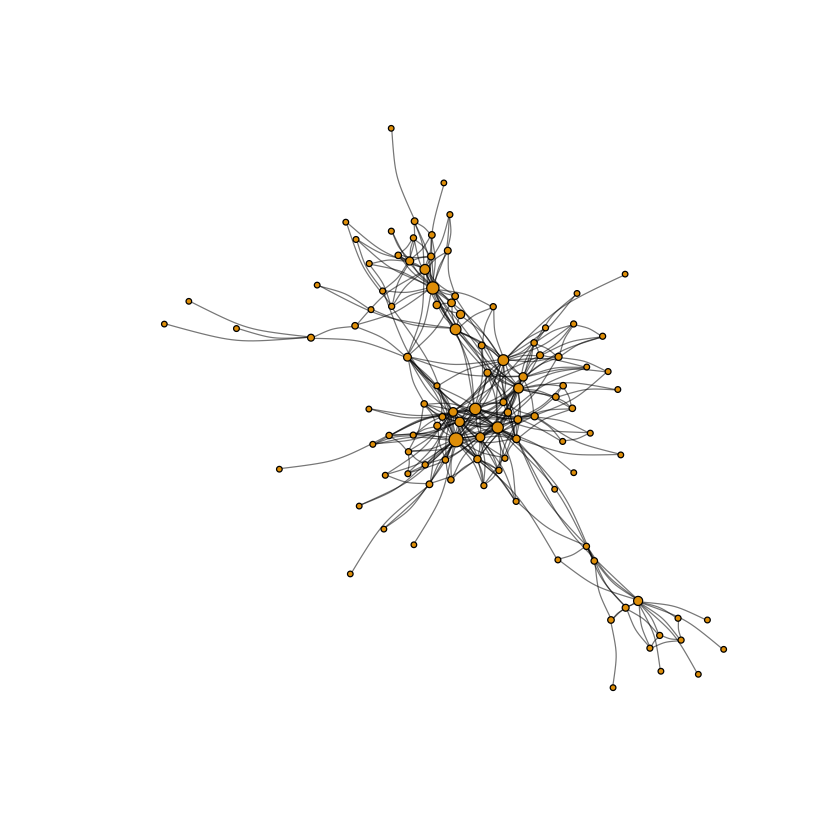

In [25]:
plot(got_graph,
     vertex.size = nodesize_strength,
     vertex.label = NA,
     edge.color="#00000088",
     edge.curved=.2)

The *Game of Thrones* graph consists of a single connected component, but is there a modular community structure within that component, and what does it look like?


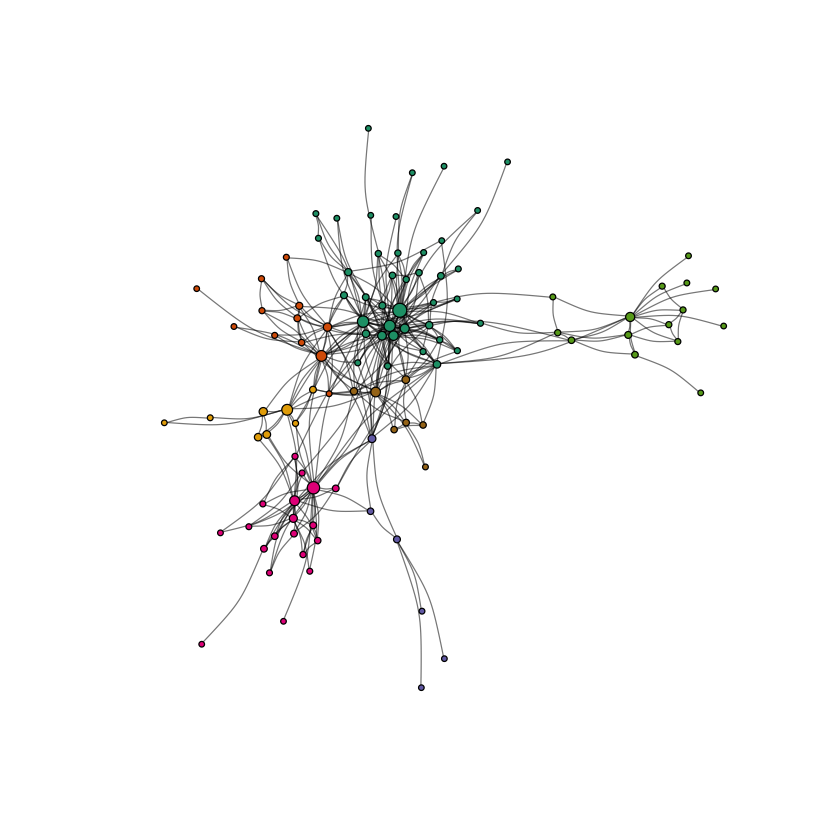

In [26]:
# implement fast greedy modularity optimization algorithm 
# to find community structure
communities <- cluster_fast_greedy(got_graph)

# assign community membership as vertex attribute 
V(got_graph)$community <- communities$membership
commnunity_pal <- brewer.pal(max(V(got_graph)$community), "Dark2")

# plot, coloring nodes by community membership
plot(got_graph,
     vertex.size = nodesize_strength,
     vertex.color = commnunity_pal[V(got_graph)$community],
     vertex.label = NA,
     edge.color="#00000088",
     edge.curved=.2)

You could also visualize the communities by "marking" (outlining) them:

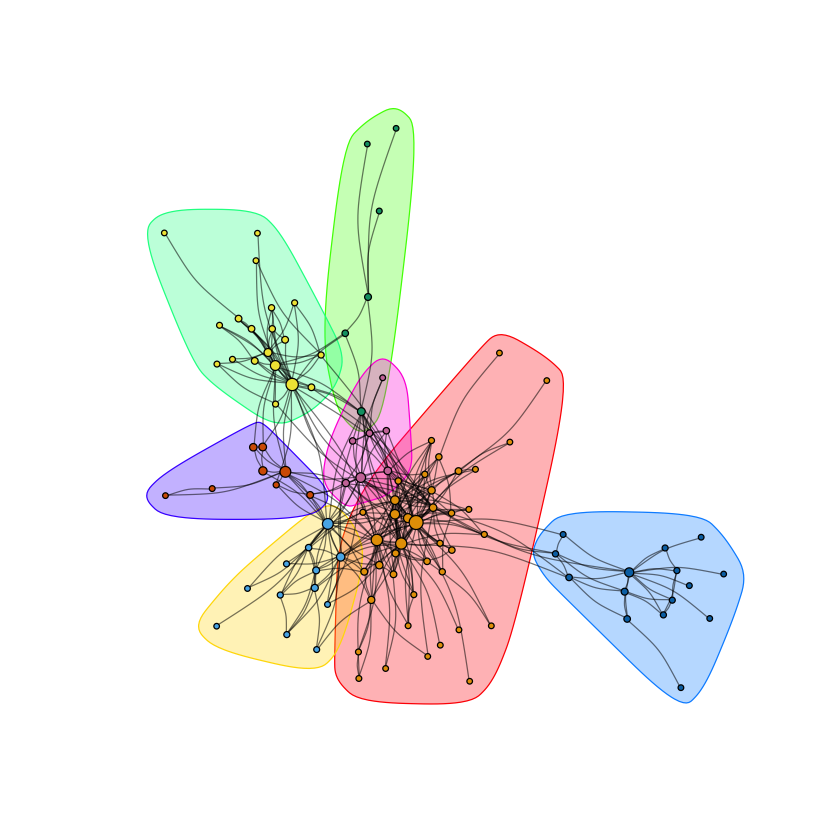

In [27]:
plot(communities, 
     got_graph,
     vertex.size = nodesize_strength,
     vertex.label = NA,
     edge.color="#00000088",
     edge.curved=.2)

As you can see, the graph has been partitioned into 7 communities. 

You could try to see who is in which community by commenting out the "vertex.label = NA" argument above. They may be hard to read since there are so many labels, so we can instead just inspect the communities directly. For example:

In [28]:
cluster_fast_greedy(got_graph)[[4]]

cluster_fast_greedy(got_graph)[[5]]

[1] "Aemon"       "Alliser"     "Craster"     "Eddison"     "Gilly"      
 [6] "Janos"       "Jon"         "Mance"       "Rattleshirt" "Samwell"    
[11] "Val"         "Ygritte"     "Grenn"       "Karl"        "Bowen"      
[16] "Dalla"       "Orell"       "Qhorin"      "Styr"

[1] "Belwas"    "Daario"    "Daenerys"  "Irri"      "Jorah"     "Missandei"
 [7] "Rhaegar"   "Viserys"   "Barristan" "Illyrio"   "Drogo"     "Aegon"    
[13] "Kraznys"   "Rakharo"   "Worm"

If you're familiar with these characters at all, you can see that  the communities are comprised of people whose storylines unfold together.

### Extracting information about nodes and edges
Finally, because more of you will be familiar with the relaltionships among these characters than among our anonymous subjects in the real-world social network we visualized earlier, we'll use the *Game of Thrones* network to quickly illustrate a couple more concepts regarding social network measures, and more generally, about extracting information about particular nodes.

For example, we can also extract only edges that meet certain criteria -- e.g., we can see whose names are mentioned together more than 75 times:

In [29]:
E(got_graph)[weight>75]

+ 3/352 edges from 79e4f2e (vertex names):
[1] Bran   --Hodor  Brienne--Jaime  Sansa  --Tyrion

If you're familiar with these characters, this probably seems reasonable to you.

We can also characterize things about each node.

For example, we can also extract a given node's neighbors (i.e., direct connections):

In [30]:
neighbors(got_graph, "Hodor")

+ 4/107 vertices, named, from 79e4f2e:
[1] Bran  Jojen Meera Robb 

...And we can check on a particular relationship. For example, have Daenerys and Tyrion met yet in this book?


In [31]:
got_graph["Daenerys", "Tyrion"]

[1] 0

It doesn't look like it.

We can quickly check out who has the largest and smallest number of links with others by looking at their degree centrality (i.e., the total number of their direct connections):


In [32]:
head(sort(degree(got_graph), decreasing = TRUE))
head(sort(degree(got_graph), decreasing = FALSE))

Tyrion    Jon  Sansa   Robb  Jaime  Tywin 
    36     26     26     25     24     22

Amory Shireen  Walton Illyrio    Karl   Aegon 
      1       1       1       1       1       1

Or, since this is a weighted network, we could instead look at strength, or weighted degree centrality. This just sums the weights of edges adjacent to each node (so here, the total number of interactions):

In [33]:
head(sort(strength(got_graph), decreasing = TRUE))
head(sort(strength(got_graph), decreasing = FALSE))

Tyrion    Jon  Sansa  Jaime   Bran   Robb 
   551    442    383    372    344    342

Cressen  Ramsay   Amory Shireen   Doran    Karl 
      4       4       5       5       5       6

You could of course extract many other centrality measures as well, such as betweenness centrality (i.e., how often a node is on the shortest path between 2 other nodes).

Let's see who has high betweenness centrality -- in other words, who bridges between disparate areas of the network:


In [34]:
head(sort(betweenness(got_graph, normalized = TRUE), decreasing = TRUE))

Robert    Tyrion       Jon   Stannis     Sansa   Catelyn 
0.2095508 0.2091255 0.1656065 0.1251602 0.1228332 0.1074573

### Summing Up
Hopefully, the above exercises gave you a sense of how to input, visualize, and interpret social network data. 

In the remaining notebooks in this tutorial, we'll focus on the same real-world friendship network that you visualized above (also shown below, for convenience):

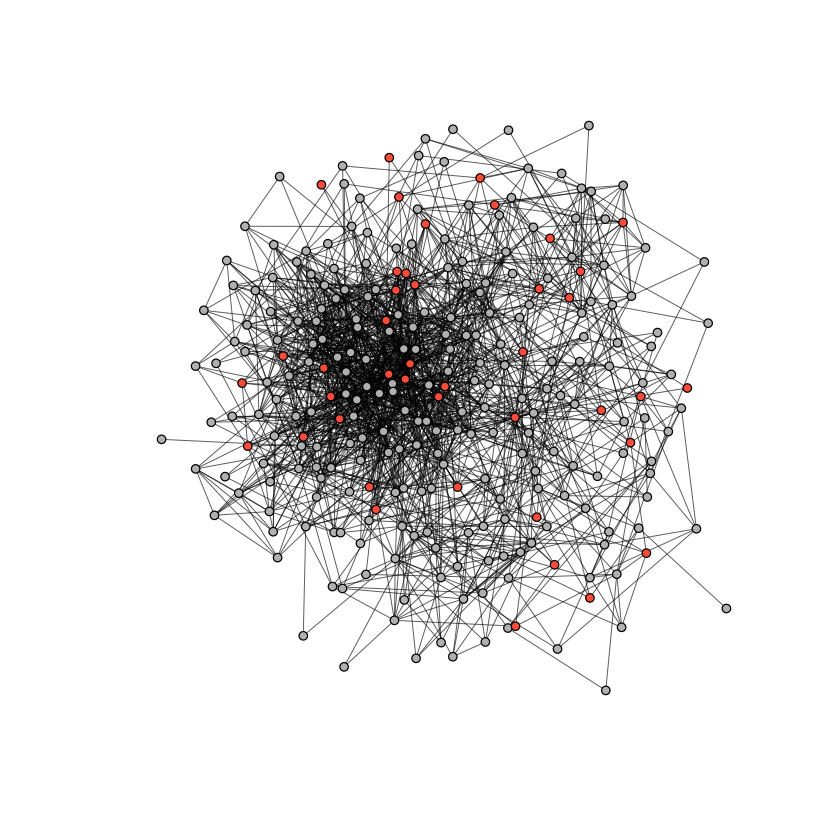

In [35]:
coords <- layout_(our_graph_mutual_no_iso, with_kk())
plot(our_graph_mutual_no_iso, vertex.label = NA, layout = coords)

Next, we'll extract neural response time series from each of the red nodes (in the next notebook).

Finally, we'll relate the neural and social network data (in the last notebook).